# Imports

In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim
import random
from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModel

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device, random_word_mask, my_collate
get_global("cache_dir")
from facebook_hateful_memes_detector.models import MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


In [2]:
# data = get_datasets(data_dir="../data/", train_text_transform=None, train_image_transform=None, 
#                     test_text_transform=None, test_image_transform=None, 
#                     cache_images = True, use_images = False, dev=False, test_dev=True,
#                     keep_original_text=False, keep_original_image=False, 
#                     keep_processed_image=True, keep_torchvision_image=False,)

# texts = list(data["train"].text.values) + list(data["test"].text.values) + list(data["dev"].text.values)
# pd.DataFrame({"texts": texts}).to_csv("text.csv", header=False, index=False)


In [3]:
initial_model = "/home/ahemf/cache/distilbert-nsp"
model_type = "distilroberta-base"
output_model = "/home/ahemf/cache/distilbert"
batch_size = 256

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer.vocab_size

tokenizer = AutoTokenizer.from_pretrained(model_type)
tokenizer.vocab_size
tokenizer.sep_token
tokenizer.sep_token_id
tokenizer.special_tokens_map




texts = pd.read_csv("text.csv", header=None)[0].values

def save(model, tokenizer, output_dir):
    import os
    os.makedirs(output_dir, exist_ok=True)
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

scheduler_init_fn = get_cosine_schedule_with_warmup()


30522

50265

'</s>'

2

{'bos_token': '<s>',
 'eos_token': '</s>',
 'unk_token': '<unk>',
 'sep_token': '</s>',
 'pad_token': '<pad>',
 'cls_token': '<s>',
 'mask_token': '<mask>'}

https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

# Augmented/Masked Text same as Original Text - RMSE

In [4]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)
optimizer = adamw
optimizer_params = adamw_params

from transformers import AutoModelWithLMHead, AutoTokenizer, AutoModel


class BertVectorizer(torch.nn.Module):
    def __init__(self, model, sequence_length, pooled_multiplier):
        super().__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model)
        self.model = AutoModel.from_pretrained(model)
        self.sequence_length = sequence_length
        self.pooled_multiplier = pooled_multiplier

    def forward(self, texts):
        tokenizer = self.tokenizer
        n_tokens_in = self.sequence_length
        converted_texts = tokenizer.batch_encode_plus(texts,
                                                      add_special_tokens=True,
                                                      pad_to_max_length=True,
                                                      max_length=n_tokens_in,
                                                      truncation=True)
        input_ids, attention_mask = converted_texts[
            "input_ids"], converted_texts["attention_mask"]
        input_ids, attention_mask = torch.tensor(input_ids).to(
            get_device()), torch.tensor(attention_mask).to(get_device())
        outputs = self.model(input_ids, attention_mask=attention_mask)
        last_hidden_states = outputs[0]
        pooled_output = outputs[1].unsqueeze(1)
        pooled_output = pooled_output * self.pooled_multiplier
        output = torch.cat((pooled_output, last_hidden_states), 1)
        return output


from torchtext.data import Dataset, TabularDataset, Field
dataset = Dataset(texts, [("text", Field())])

epochs = 5
batch_size = 128
lr_strategy = {
    "model": {
        "finetune": False,
        "encoder": {
            "layer": {
                "4": {"finetune": True},
                "5": {"finetune": True},
                "lr": optimizer_params["lr"],
            },
            "finetune": False,
            
        },
    }
}


def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.8, 0.1], char_level)
    word_level = {"fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.2,
                 "stopword_insert": 0.0, "word_join": 0.2, "word_cutout": 0.8, "gibberish_insert": 0.0}
    word_level = TextAugment([0.2, 0.7, 0.1], word_level)
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, 
                      "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.75}
    sentence_level = TextAugment([0.75, 0.25], sentence_level)
    gibberish = {"gibberish_insert": 0.25, "punctuation_insert": 0.75,}
    gibberish = TextAugment([0.75, 0.25], gibberish)
    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        text = gibberish(text)
        return text
    return process

preprocess_text = get_preprocess_text()

vectorized_text_processor = np.vectorize(preprocess_text)

model_fn = model_builder(
    BertVectorizer,
    dict(sequence_length=96, pooled_multiplier=4,
         model=initial_model),  # initial_model
    per_param_opts_fn=lr_strategy,
    optimiser_class=optimizer,
    optimiser_params=optimizer_params)




In [ ]:



def augment_method(texts):
    mask_proba = 0.15
    texts = [random_word_mask(t, model.tokenizer, mask_proba) for t in texts]
    return vectorized_text_processor(texts)




model, optim = model_fn()
_ = train_for_augment_similarity(model,
                                 optim,
                                 scheduler_init_fn,
                                 batch_size,
                                 epochs,
                                 dataset,
                                 augment_method=augment_method,
                                 model_call_back=None,
                                 accumulation_steps=2,
                                 plot=True)

# 0.06687

save(model.model, model.tokenizer, output_dir=output_model + "-augsim")


# Coherence [Not useful]
- Two halves belong to same sentence 
- Is first half swapped with 2nd half

In [ ]:
from torch.utils.data import Dataset, DataLoader
from mmf.common.sample import Sample, SampleList
import random



def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.8, 0.1], char_level)
    word_level = {"fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.2,
                 "stopword_insert": 0.0, "word_join": 0.2, "word_cutout": 0.8, "gibberish_insert": 0.0}
    word_level = TextAugment([0.2, 0.7, 0.1], word_level)
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, 
                      "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.75}
    sentence_level = TextAugment([0.75, 0.25], sentence_level)
    gibberish = {"gibberish_insert": 0.25, "punctuation_insert": 0.75,}
    gibberish = TextAugment([0.75, 0.25], gibberish)
    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        text = gibberish(text)
        return text
    return process

preprocess_text = get_preprocess_text()

def split(text):
    parts = text.split()
    half = len(parts) // 2
    return " ".join(parts[:half]), " ".join(parts[half:])
class CoherenceDataset(Dataset):
    def __init__(self, texts, preprocess_text, separator_token):
        self.texts = list(texts)
        self.sep = separator_token
        self.preprocess_text = preprocess_text
        
    def __getitem__(self, item):
        org_text = self.texts[item]
        text = self.preprocess_text(org_text) if random.random() < 0.25 else org_text
        text_part_1, text_part_2 = split(text)
        if random.random() < 0.5:
            if random.random() < 0.5:
                return Sample({"text": self.__build_split__(text_part_1, text_part_2), "label": 1})
            else:
                return Sample({"text": self.__build_split__(text_part_2, text_part_1), "label": 0})
        else:
            text2 = random.sample(self.texts, 1)[0]
            text2 = self.preprocess_text(text2) if random.random() < 0.25 else text2
            text2_part_1, text2_part_2 = split(text2)
            if random.random() < 0.5:
                if random.random() < 0.5:
                    return Sample({"text": self.__build_split__(text_part_1, text2_part_2), "label": 2})
                else:
                    return Sample({"text": self.__build_split__(text2_part_1, text_part_2), "label": 2})
            else:
                if random.random() < 0.6:
                    return Sample({"text": self.__build_split__(text, text2), "label": 2})
                else:
                    if random.random() < 0.5:
                        return Sample({"text": self.__build_split__(org_text, text), "label": 3})
                    else:
                        return Sample({"text": self.__build_split__(text, org_text), "label": 3})
    
    def __build_split__(self, text_part_1, text_part_2):
        if random.random() < 0.5:
            return text_part_1 + self.sep + text_part_2
        else:
            return text_part_1 + text_part_2
            
    def __len__(self):
        return len(self.texts)
          
    
model_name = initial_model # output_model + "-mlm"

optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)

dataset = CoherenceDataset(texts, preprocess_text, f" {tokenizer.sep_token} ")

epochs = 20
batch_size=256
lr_strategy = {
    "model": {
        "finetune": False,
    }
}

model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=4,
                              gaussian_noise=0.0,
                              dropout=0.0,
                              word_masking_proba=0.0,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=0,
                              n_encoders=1,
                              n_decoders=0,
                              n_tokens_in=96 * 2,
                              n_tokens_out=48,
                              featurizer="transformer",
                              classification_head="head_ensemble",
                              model=output_model + "-augsim",
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer_class,
                         optimiser_params=optimizer_params)


model, optimizer = model_fn()
train_losses, learning_rates = train(model, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=1, plot=True,
                                     sampling_policy=None, class_weights=None)

validate(model, batch_size, dataset, display_detail=False)


In [ ]:

###

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "finetune": False,
            "layer": {
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True,
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True,
                }
            }
            
        },
    },
    "final_layer": {
        "lr": optimizer_params["lr"],
    }
}
epochs = 8
batch_size=128
optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=2e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-4)

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)

train_losses, learning_rates = train(model, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=2, plot=True,
                                     sampling_policy=None, class_weights=None)

res_cor = validate(model, batch_size, dataset, display_detail=True)
res_cor

save(model.model, model.tokenizer, output_dir=output_model + "-cor")


# NSP Dual Model

- This task hasn't shown usefulness

In [ ]:
from torch.utils.data import Dataset, DataLoader
from mmf.common.sample import Sample, SampleList
import random

from facebook_hateful_memes_detector.preprocessing import NegativeSamplingDataset

from torchtext.data import Dataset, TabularDataset, Field
dataset = Dataset(texts, [("text", Field())])
ns_dataset = NegativeSamplingDataset(dataset, 5)

def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.8, 0.1], char_level)
    word_level = {"fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.2,
                 "stopword_insert": 0.0, "word_join": 0.2, "word_cutout": 0.8, "gibberish_insert": 0.0}
    word_level = TextAugment([0.2, 0.7, 0.1], word_level)
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, 
                      "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.75}
    sentence_level = TextAugment([0.75, 0.25], sentence_level)
    gibberish = {"gibberish_insert": 0.25, "punctuation_insert": 0.75,}
    gibberish = TextAugment([0.75, 0.25], gibberish)
    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        text = gibberish(text)
        return text
    return process

preprocess_text = get_preprocess_text()

class BertDualClassifier(torch.nn.Module):
    def __init__(self, model, n_tokens_in, word_masking_proba, preprocess_text):
        super().__init__()
        self.model = model
        self.preprocess_text = preprocess_text
        if type(self.model) == str:
            self.model = AutoModel.from_pretrained(self.model)
            self.tokenizer = AutoTokenizer.from_pretrained(model)
            
        self.classifier = nn.Sequential(nn.Linear(768 * 2, 256), nn.LeakyReLU(), nn.Linear(256, 2))
        self.loss = nn.CrossEntropyLoss()
        self.n_tokens_in = n_tokens_in
        self.word_masking_proba = word_masking_proba
        
    def tokenise(self, texts: List[str]):
        texts = [self.preprocess_text(t) if random.random() < 0.5 else t for t in texts]
        tokenizer = self.tokenizer
        n_tokens_in = self.n_tokens_in
        if self.training and self.word_masking_proba > 0:
            texts = [random_word_mask(t, tokenizer, self.word_masking_proba) for t in texts]
        converted_texts = tokenizer.batch_encode_plus(texts, add_special_tokens=True, pad_to_max_length=True, max_length=n_tokens_in, truncation=True)
        input_ids, attention_mask = converted_texts["input_ids"], converted_texts["attention_mask"]
        return torch.tensor(input_ids).to(get_device()), torch.tensor(attention_mask).to(get_device())
        
    def forward(self, texts):
        inp1 = texts[0]
        inp2 = texts[1]
        labels = texts[2].to(get_device())
        
        input_ids_1, attention_mask_1 = self.tokenise(inp1)
        input_ids_1, attention_mask_1 = input_ids_1.to(get_device()), attention_mask_1.to(get_device())
        input_ids_2, attention_mask_2 = self.tokenise(inp2)
        input_ids_2, attention_mask_2 = input_ids_2.to(get_device()), attention_mask_2.to(get_device())
        
        outputs_1 = self.model(input_ids_1, attention_mask=attention_mask_1)
        outputs_2 = self.model(input_ids_2, attention_mask=attention_mask_2)
        pooled_output_states_1 = outputs_1[1]
        pooled_output_states_2 = outputs_2[1]
        
        pooled_output = torch.cat([pooled_output_states_1, pooled_output_states_2], 1)
        logits = self.classifier(pooled_output)
        loss = self.loss(logits, labels.long())
        logits = logits.type(torch.float)
        return logits,0,0, loss

model_name = output_model + "-cor"

adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.99), eps=1e-08, weight_decay=1e-4)
optimizer_class = adamw
optimizer_params = adamw_params
scheduler_init_fn = get_cosine_schedule_with_warmup()


epochs = 5
batch_size = 128
lr_strategy = {
    "model": {
        "finetune": False,
    }
}

model_fn = model_builder(BertDualClassifier,
                         dict(model=model_name, n_tokens_in=96, 
                              word_masking_proba=0.0, preprocess_text=preprocess_text),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer_class,
                         optimiser_params=optimizer_params)


# 0.13393
# 0.087709

model, optimizer = model_fn()
indices = torch.randperm(len(ns_dataset))
indices_small_start = int(0.5 * len(ns_dataset))
indices_small_end = int(1.0 * len(ns_dataset))
print(indices_small_start, indices_small_end)

ns_dataset_sm_train = torch.utils.data.Subset(ns_dataset, indices[:indices_small_start])
ns_dataset_sm_test = torch.utils.data.Subset(ns_dataset, indices[indices_small_start: indices_small_end])

train_losses, learning_rates = train(model, optimizer, scheduler_init_fn, batch_size, epochs, ns_dataset,
                                     model_call_back=None, accumulation_steps=2, plot=True,
                                     collate_fn=None,
                                     sampling_policy=None, class_weights=None)

validate(model, batch_size, ns_dataset, display_detail=True, collate_fn=None,)


lr_strategy = {
    "model": {
        "finetune": False,
        "encoder": {
            "layer": {
                "4": {"finetune": True},
                "5": {"finetune": True},
                "lr": optimizer_params["lr"],
            },
            "finetune": False,
            
        },
    },
    "final_layer": {
        "lr": optimizer_params["lr"],
    }
}

model.no_grad = False
batch_size = 128
epochs = 5
optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=1e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-5)

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)

train_losses, learning_rates = train(model, optimizer, scheduler_init_fn, batch_size, epochs, ns_dataset,
                                     model_call_back=None, accumulation_steps=2, plot=True,
                                     collate_fn=None,
                                     sampling_policy=None, class_weights=None)

res_nsp_dual = validate(model, batch_size, ns_dataset, display_detail=True, collate_fn=None)
res_nsp_dual

save(model.model, model.tokenizer, output_dir=output_model + "-nsp-dual")



# NSP Style Pretraining

In [ ]:
from torch.utils.data import Dataset, DataLoader
from mmf.common.sample import Sample, SampleList
import random

def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.8, 0.1], char_level)
    word_level = {"fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.2,
                 "stopword_insert": 0.0, "word_join": 0.2, "word_cutout": 0.8, "gibberish_insert": 0.0}
    word_level = TextAugment([0.2, 0.7, 0.1], word_level)
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, 
                      "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.75}
    sentence_level = TextAugment([0.75, 0.25], sentence_level)
    gibberish = {"gibberish_insert": 0.25, "punctuation_insert": 0.75,}
    gibberish = TextAugment([0.75, 0.25], gibberish)
    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        text = gibberish(text)
        return text
    return process

preprocess_text = get_preprocess_text()

class DiscriminatoryTextDataset(Dataset):
    def __init__(self, texts, process_text, separator_token):
        self.texts = list(texts)
        self.process_text = process_text
        self.separator_token = separator_token
        
    def __getitem__(self, item):
        process_text = self.process_text
        text = self.texts[item]
        separator_token = self.separator_token
        if random.random() < 0.15:
            rand = random.random()
            if rand < 0.5:
                return Sample({"text": text+separator_token+text, "label": 1})
            elif rand < 0.7:
                return Sample({"text": text+separator_token+process_text(text), "label": 1})
            elif rand < 0.9:
                return Sample({"text": process_text(text)+separator_token+text, "label": 1})
            else:
                return Sample({"text": process_text(text)+separator_token+process_text(text), "label": 1})
        else:
            rt = random.sample(self.texts, 1)[0]
            rand = random.random()
            if rand < 0.5:
                return Sample({"text": text+separator_token+rt, "label": 0})
            elif rand < 0.7:
                return Sample({"text": text+separator_token+process_text(rt), "label": 0})
            elif rand < 0.9:
                return Sample({"text": process_text(text)+separator_token+rt, "label": 0})
            else:
                return Sample({"text": process_text(text)+separator_token+process_text(rt), "label": 0})
            
    
    def __len__(self):
        return len(self.texts)
    
model_name = output_model + "-nsp-dual" # "-augsim"

adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)
optimizer_class = adamw
optimizer_params = adamw_params
scheduler_init_fn = get_cosine_schedule_with_warmup()


dataset = DiscriminatoryTextDataset(texts, preprocess_text, f" {tokenizer.sep_token} ")


epochs = 3
lr_strategy = {
    "model": {
        "finetune": False,
    }
}

model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.0,
                              dropout=0.0,
                              word_masking_proba=0.15,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=0,
                              n_encoders=1,
                              n_decoders=0,
                              n_tokens_in=96*2,
                              n_tokens_out=4,
                              featurizer="transformer",
                              classification_head="cnn1d",
                              model=model_name,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer_class,
                         optimiser_params=optimizer_params)


# 0.13393
# 0.087709

model, optimizer = model_fn()
train_losses, learning_rates = train(model, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=1, plot=True,
                                     sampling_policy=None, class_weights=None)

validate(model, batch_size, dataset, display_detail=True)

lr_strategy = {
    "model": {
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {"finetune": True},
                "4": {"finetune": True},
                "5": {"finetune": True},
                "lr": optimizer_params["lr"],
            },
            "finetune": False,
            
        },
    },
    "final_layer": {
        "lr": optimizer_params["lr"],
    }
}
epochs = 5
optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=1e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-4)

_ = group_wise_finetune(model, lr_strategy)
params_conf, _ = group_wise_lr(model, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)

train_losses, learning_rates = train(model, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=1, plot=True,
                                     sampling_policy=None, class_weights=None)

res_nsp = validate(model, batch_size, dataset, display_detail=True)
res_nsp

save(model.model, model.tokenizer, output_dir=output_model + "-nsp")


# SimCLR

In [ ]:
# Define texts
# Define SimCLR LM wrapper
# Use dataset as text dataset
# Perform SimCLR on only SimCLR head, then do SimCLR on whole model


In [5]:
def get_preprocess_text():
    char_level = {"keyboard": 0.1, "char_substitute": 0.4, "char_insert": 0.2, "char_swap": 0.2, 
                  "ocr": 0.0, "char_delete": 0.1}
    char_level = TextAugment([0.1, 0.8, 0.1], char_level)
    word_level = {"fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.2,
                 "stopword_insert": 0.0, "word_join": 0.2, "word_cutout": 0.8, "gibberish_insert": 0.0}
    word_level = TextAugment([0.2, 0.7, 0.1], word_level)
    sentence_level = {"text_rotate": 0.0, "sentence_shuffle": 0.0, 
                      "one_third_cut": 0.3, "half_cut":0.0, "part_select": 0.75}
    sentence_level = TextAugment([0.75, 0.25], sentence_level)
    gibberish = {"gibberish_insert": 0.25, "punctuation_insert": 0.75,}
    gibberish = TextAugment([0.75, 0.25], gibberish)
    def process(text):
        text = sentence_level(text)
        text = word_level(text)
        text = char_level(text)
        text = gibberish(text)
        return text
    return process

preprocess_text = get_preprocess_text()

vectorized_text_processor = np.vectorize(preprocess_text)

from facebook_hateful_memes_detector.utils import SimCLR
model = BertVectorizer(output_model + "-nsp", sequence_length=96, pooled_multiplier=1,)
smclr = SimCLR(model, 768, 256, 0.1, vectorized_text_processor, vectorized_text_processor)




Autocast =  True Epochs =  5 Divisor = 1 Examples = 10000 Batch Size =  512
Training Samples =  10000 Weighted Sampling =  False Num Batches =  20 Accumulation steps =  1



Epoch =  1 Loss = 5.771142 LR = 0.00006667



Epoch =  2 Loss = 5.554954 LR = 0.00009505



Epoch =  3 Loss = 5.047556 LR = 0.00006113



Epoch =  4 Loss = 4.606799 LR = 0.00001883



Epoch =  5 Loss = 4.458236 LR = 0.00000000



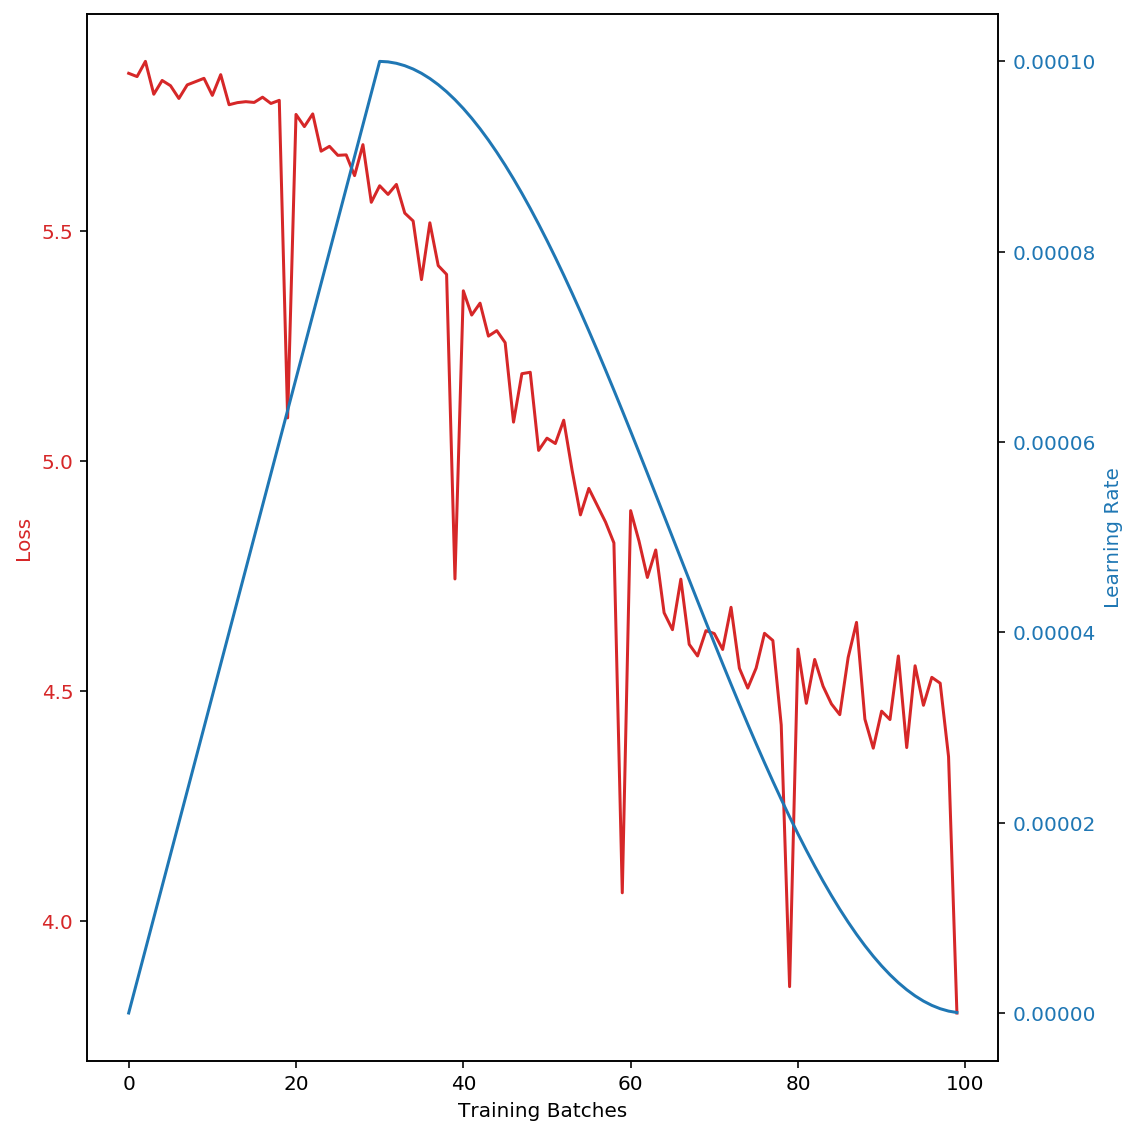

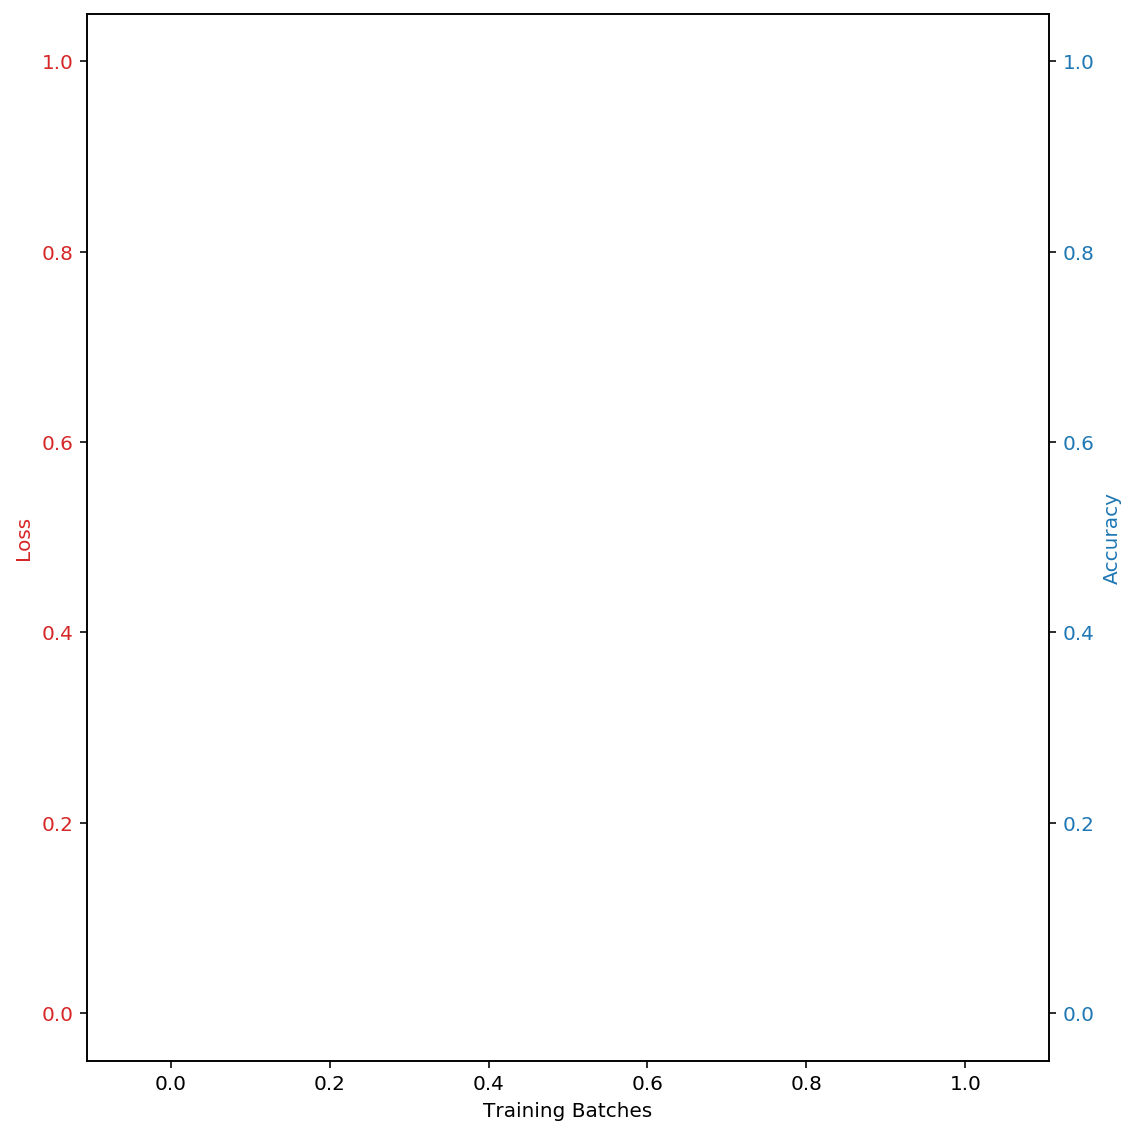


MLM Accuracy = 0.3239


0.3239

In [6]:
lr_strategy = {
    "model": {
        "model": {
            "finetune": False,
        }
    },
    "final_layer": {
        "finetune": True
    }
}

epochs = 5
batch_size = 512
optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=1e-4,
                        betas=(0.9, 0.98),
                        eps=1e-08,
                        weight_decay=1e-2)

smclr = smclr.to(get_device())
_ = group_wise_finetune(smclr, lr_strategy)
params_conf, _ = group_wise_lr(smclr, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)
train_losses, learning_rates = train(smclr,
                                     optimizer,
                                     scheduler_init_fn,
                                     batch_size,
                                     epochs,
                                     dataset,
                                     model_call_back=None,
                                     accumulation_steps=1,
                                     plot=True,
                                     collate_fn=None,
                                     sampling_policy=None,
                                     class_weights=None)

smclr.plot_loss_acc_hist()
smclr.test_accuracy(batch_size, dataset, collate_fn=None)


Autocast =  True Epochs =  20 Divisor = 1 Examples = 10000 Batch Size =  512
Training Samples =  10000 Weighted Sampling =  False Num Batches =  20 Accumulation steps =  1



Epoch =  1 Loss = 4.424977 LR = 0.00000167



Epoch =  2 Loss = 4.293010 LR = 0.00000333


Exception for:  keyboard | ' ' | ['char_swap' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  3 Loss = 4.063824 LR = 0.00000500



Epoch =  4 Loss = 3.698465 LR = 0.00000667



Epoch =  5 Loss = 3.265917 LR = 0.00000833



Epoch =  6 Loss = 2.830204 LR = 0.00001000



Epoch =  7 Loss = 2.414668 LR = 0.00000987


Exception for:  keyboard | '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  8 Loss = 2.119633 LR = 0.00000950



Epoch =  9 Loss = 1.910814 LR = 0.00000891



Epoch =  10 Loss = 1.742178 LR = 0.00000812



Epoch =  11 Loss = 1.650904 LR = 0.00000717



Epoch =  12 Loss = 1.532251 LR = 0.00000611



Epoch =  13 Loss = 1.473544 LR = 0.00000500



Epoch =  14 Loss = 1.426036 LR = 0.00000389


Exception for:  keyboard | '' '' | ['keyboard'] argument of type 'NoneType' is not iterable
Exception for:  keyboard | '' '' '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  15 Loss = 1.381050 LR = 0.00000283



Epoch =  16 Loss = 1.360518 LR = 0.00000188



Epoch =  17 Loss = 1.362514 LR = 0.00000109



Epoch =  18 Loss = 1.346487 LR = 0.00000050



Epoch =  19 Loss = 1.329745 LR = 0.00000013


Exception for:  keyboard | ? | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  20 Loss = 1.306530 LR = 0.00000000



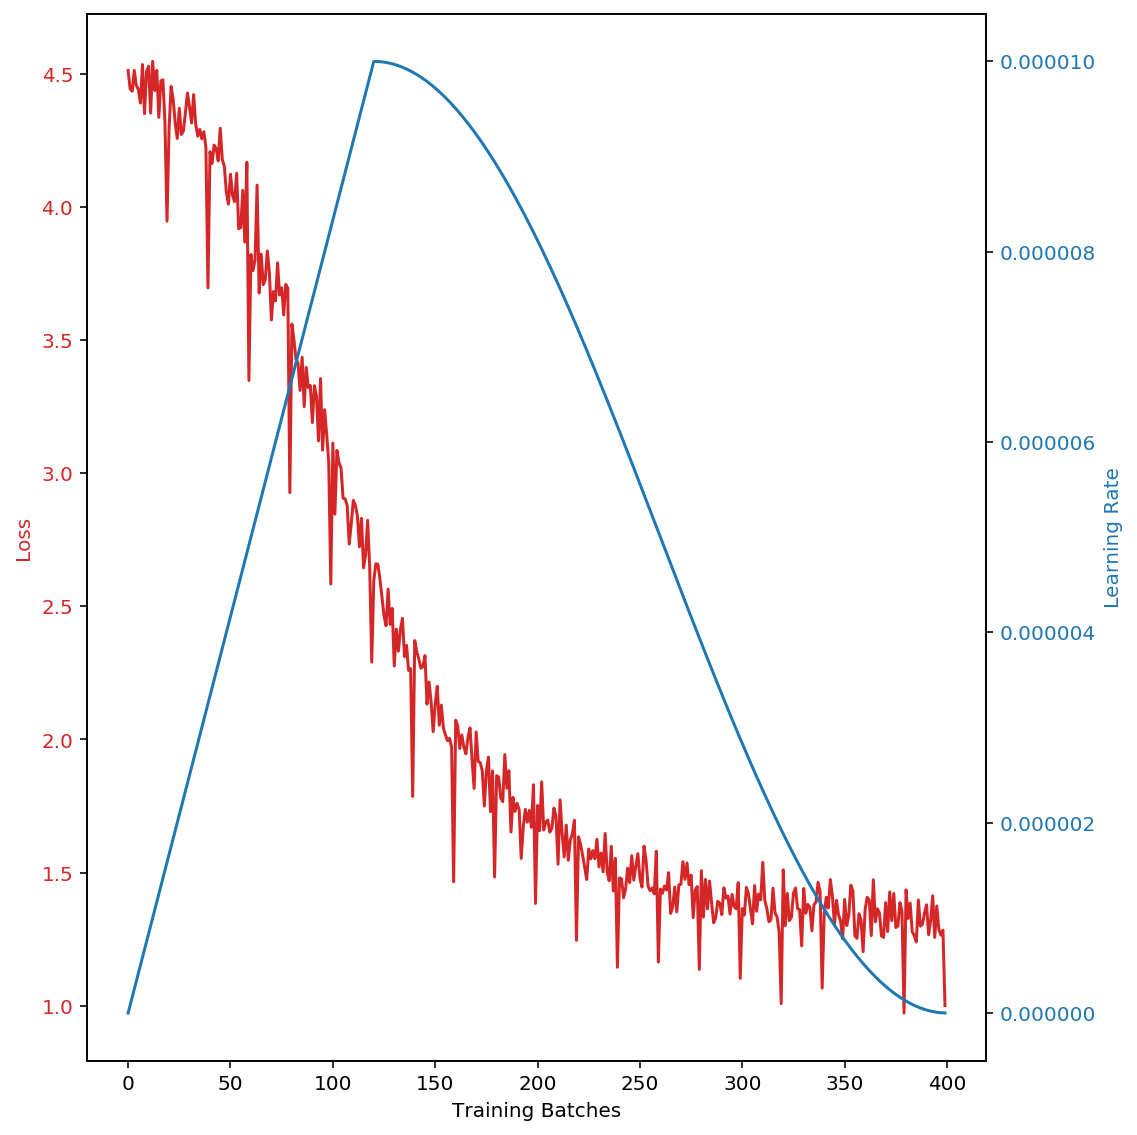

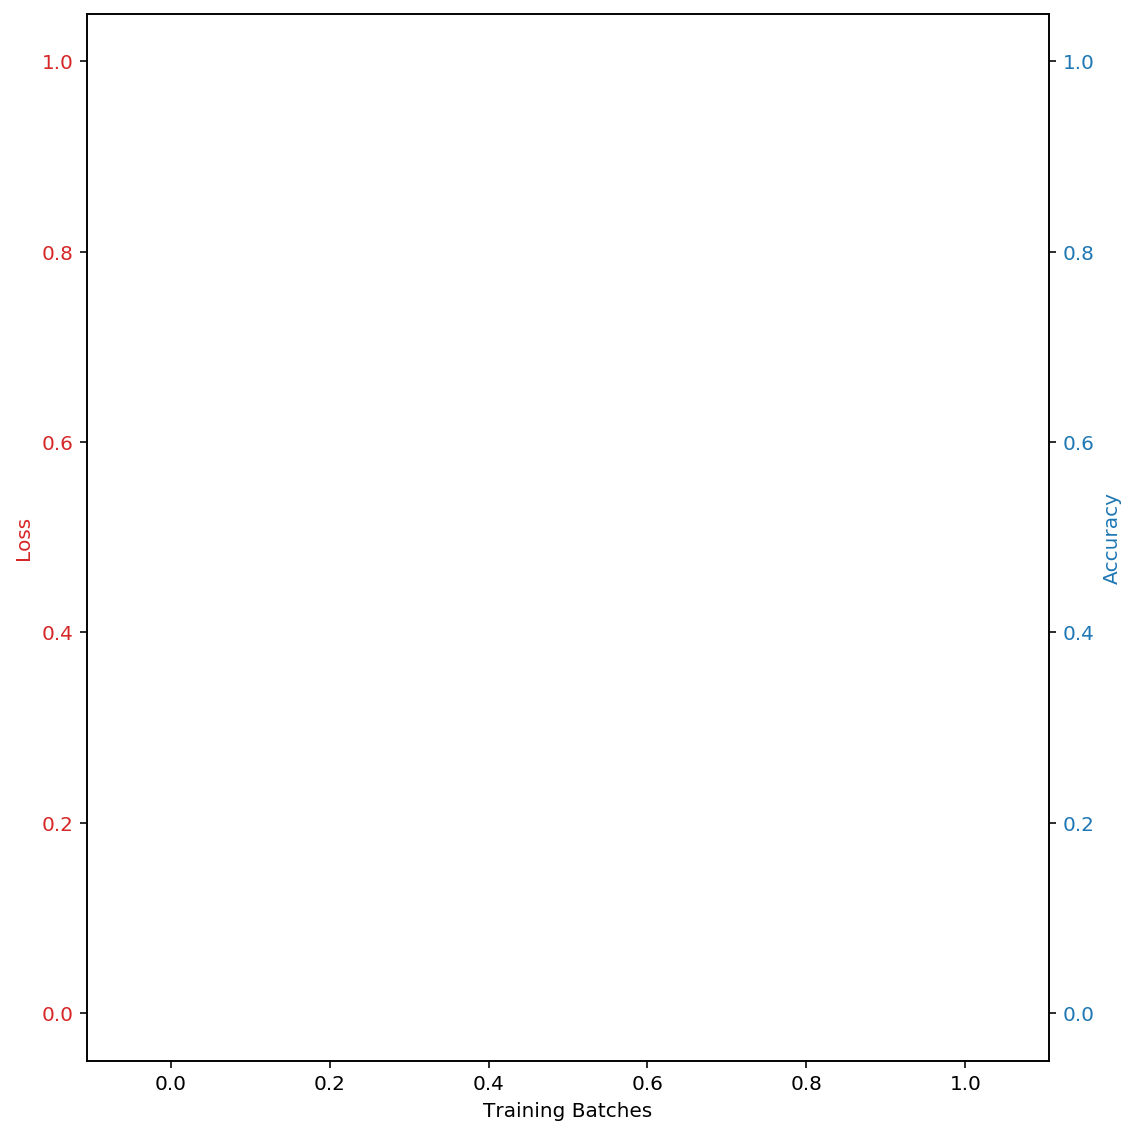


MLM Accuracy = 0.7550


In [7]:

epochs = 20
batch_size = 512
optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=1e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)

lr_strategy = {
    "model": {
        "model": {
        "finetune": False,
        "encoder": {
            "layer": {
                "4": {"finetune": True},
                "5": {"finetune": True},
                "lr": optimizer_params["lr"],
            },
            "finetune": False,
            
            },
        }
    },
    "final_layer": {
        "finetune": True
    }
    
}


_ = group_wise_finetune(smclr, lr_strategy)
params_conf, _ = group_wise_lr(smclr, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)
train_losses, learning_rates = train(smclr, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=1, plot=True, collate_fn=None,
                                     sampling_policy=None, class_weights=None)



smclr.plot_loss_acc_hist()
acc = smclr.test_accuracy(batch_size, dataset, collate_fn=None)


Autocast =  True Epochs =  10 Divisor = 1 Examples = 10000 Batch Size =  384
Training Samples =  10000 Weighted Sampling =  False Num Batches =  27 Accumulation steps =  1



Epoch =  1 Loss = 1.158763 LR = 0.00000333



Epoch =  2 Loss = 1.098696 LR = 0.00000667



Epoch =  3 Loss = 1.041352 LR = 0.00001000



Epoch =  4 Loss = 0.958915 LR = 0.00000950



Epoch =  5 Loss = 0.925777 LR = 0.00000812



Epoch =  6 Loss = 0.856752 LR = 0.00000611



Epoch =  7 Loss = 0.840622 LR = 0.00000389



Epoch =  8 Loss = 0.801352 LR = 0.00000188



Epoch =  9 Loss = 0.786335 LR = 0.00000050



Epoch =  10 Loss = 0.790065 LR = 0.00000000



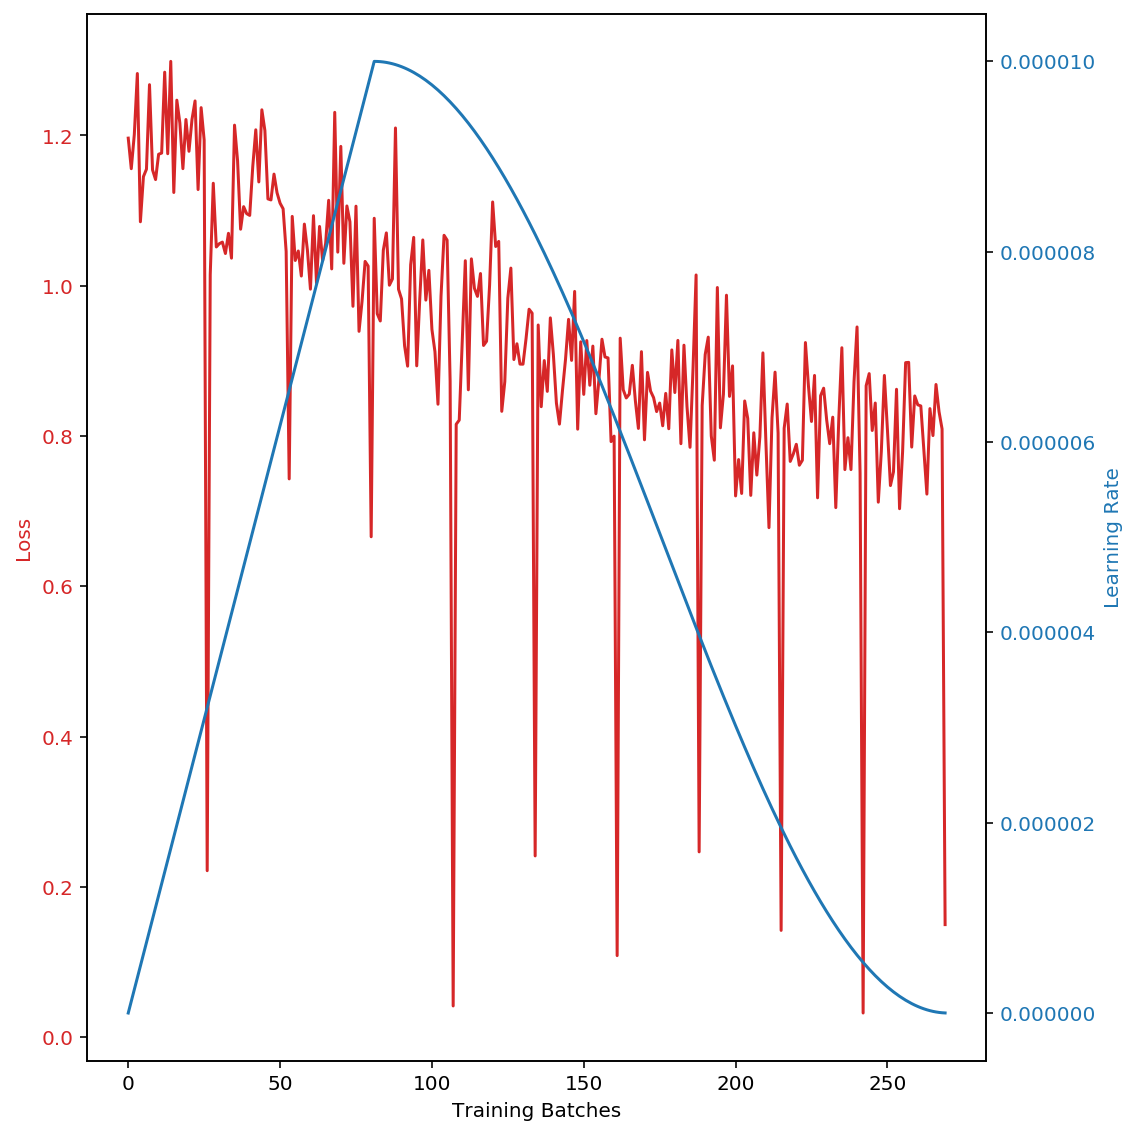

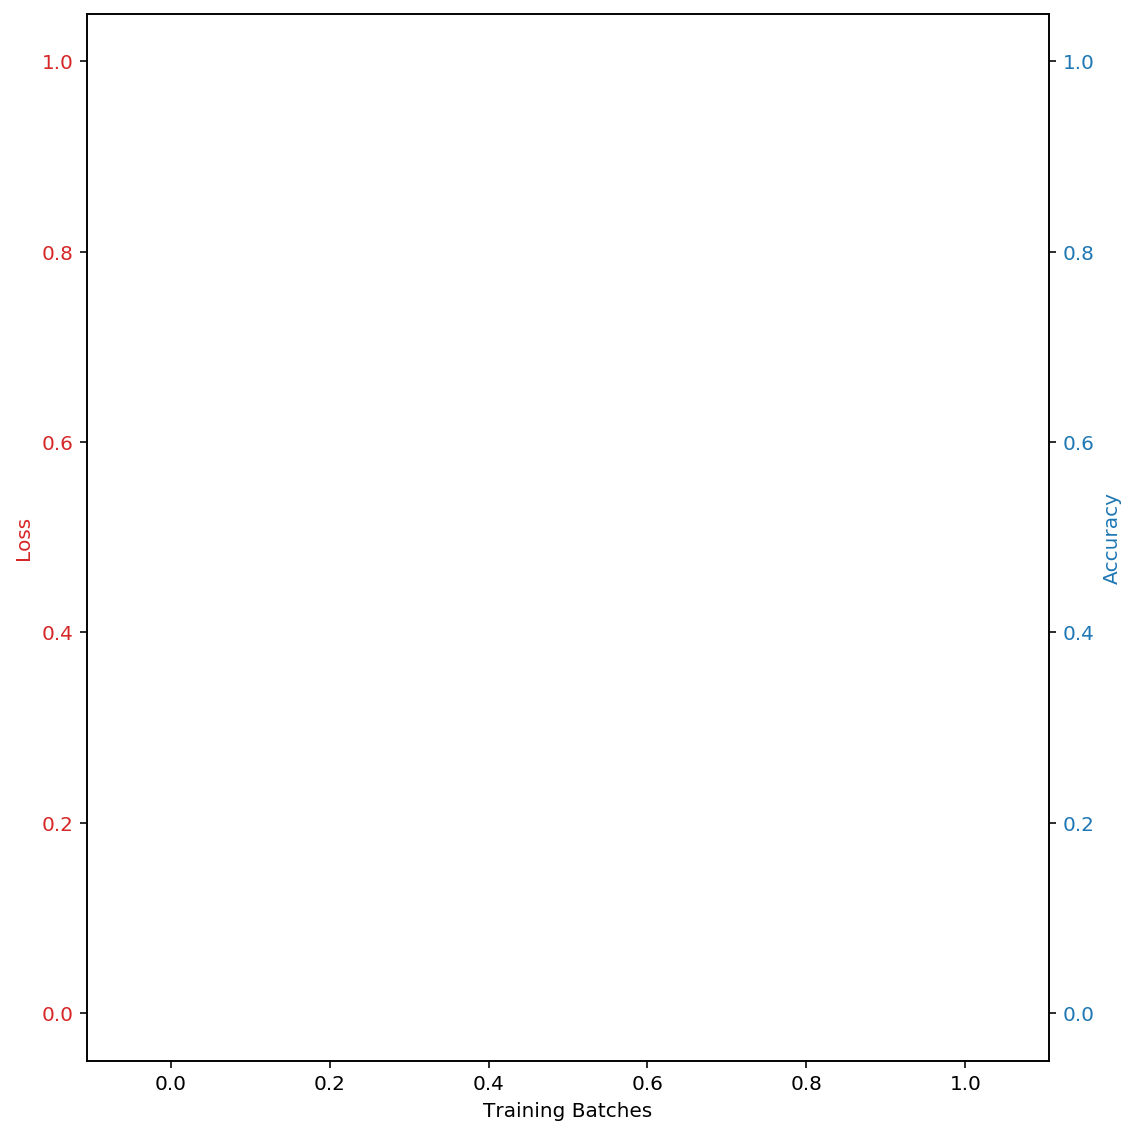


MLM Accuracy = 0.8381


In [8]:

epochs = 10
batch_size = 384
optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=1e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)

lr_strategy = {
    "model": {
        "model": {
        "finetune": False,
        "encoder": {
            "layer": {
                "3": {"finetune": True},
                "4": {"finetune": True},
                "5": {"finetune": True},
                "lr": optimizer_params["lr"],
            },
            "finetune": False,
            
            },
        }
    },
    "final_layer": {
        "finetune": True
    }
    
}


_ = group_wise_finetune(smclr, lr_strategy)
params_conf, _ = group_wise_lr(smclr, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)
train_losses, learning_rates = train(smclr, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=1, plot=True, collate_fn=None,
                                     sampling_policy=None, class_weights=None)



smclr.plot_loss_acc_hist()
acc = smclr.test_accuracy(batch_size, dataset, collate_fn=None)


Autocast =  True Epochs =  5 Divisor = 1 Examples = 10000 Batch Size =  256
Training Samples =  10000 Weighted Sampling =  False Num Batches =  40 Accumulation steps =  1


Exception for:  keyboard | '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  1 Loss = 0.638340 LR = 0.00000667



Epoch =  2 Loss = 0.599646 LR = 0.00000950


Exception for:  keyboard | '' '' | ['keyboard'] argument of type 'NoneType' is not iterable

Epoch =  3 Loss = 0.559150 LR = 0.00000611



Epoch =  4 Loss = 0.532741 LR = 0.00000188



Epoch =  5 Loss = 0.526445 LR = 0.00000000



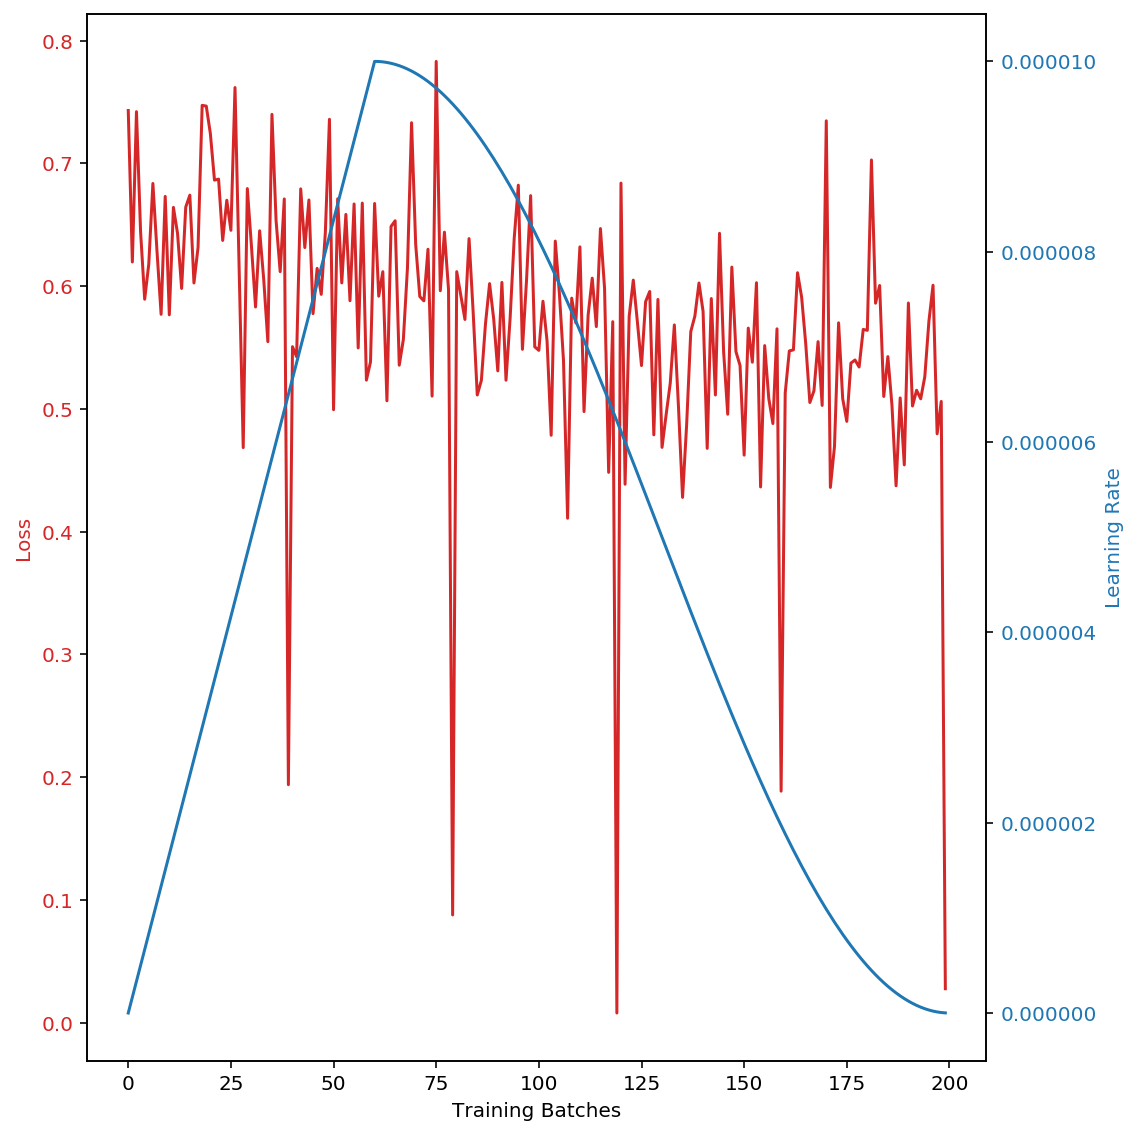

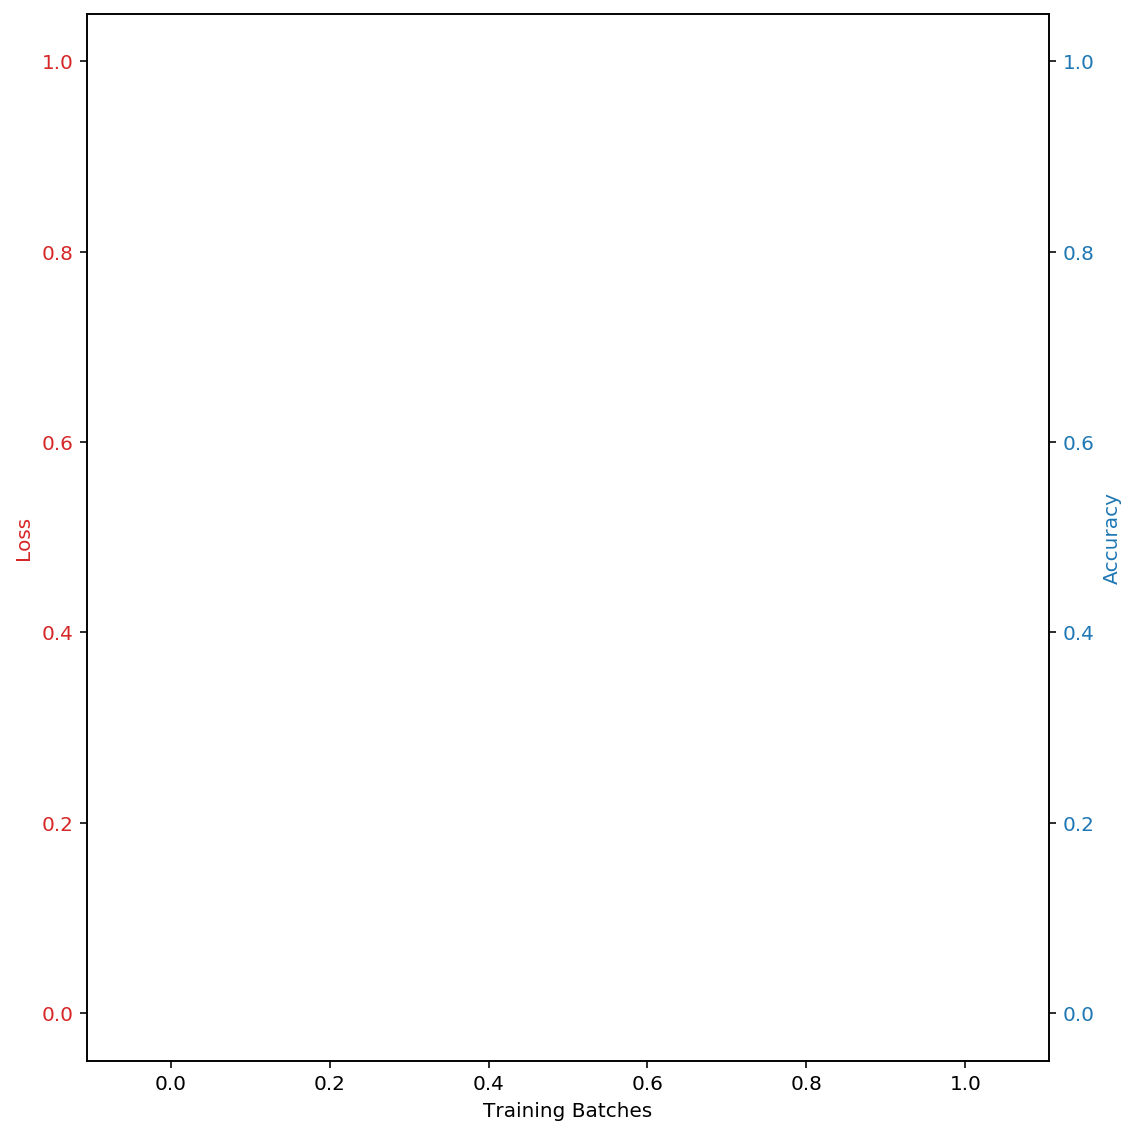


MLM Accuracy = 0.8809


In [9]:

epochs = 5
batch_size = 256
optimizer_class = torch.optim.AdamW
optimizer_params = dict(lr=1e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)

lr_strategy = {
    "model": {
        "model": {
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {"finetune": True},
                "3": {"finetune": True},
                "4": {"finetune": True},
                "5": {"finetune": True},
                "lr": optimizer_params["lr"],
            },
            "finetune": False,
            
            },
        }
    },
    "final_layer": {
        "finetune": True
    }
    
}


_ = group_wise_finetune(smclr, lr_strategy)
params_conf, _ = group_wise_lr(smclr, lr_strategy)
optimizer = optimizer_class(params_conf, **optimizer_params)
train_losses, learning_rates = train(smclr, optimizer, scheduler_init_fn, batch_size, epochs, dataset,
                                     model_call_back=None, accumulation_steps=1, plot=True, collate_fn=None,
                                     sampling_policy=None, class_weights=None)



smclr.plot_loss_acc_hist()
acc = smclr.test_accuracy(batch_size, dataset, collate_fn=None)



In [10]:
save(smclr.model.model, smclr.model.tokenizer, output_dir=output_model + "-smclr")


# CAP - Cluster Assignment Prediction
- Assign clusters using one view/Aug
- Use other Augs and predict the previous assignment
- This is very similar to AugSim
